# **Import Libraries & Mount Drive**

In [ ]:
# import stuff
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from PIL import Image
import io
import random
from keras import backend as K

In [ ]:
!nvidia-smi

Mon Dec  4 16:04:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
"""
allows the file to access your google drive
to use:
1) run cell
2) permit access
"""
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Data**

After running this section, access via: X_train,X_test,y_train,y_test

In [ ]:
"""
load data from directory into X (image) and y (label)
"""

X = []
y = []
image_size = 224  # actual image size is 512, VGG model wants 224 images

classes = os.listdir("/content/drive/My Drive/data_2/Training")  # types of tumor

# loop through directory
for i in classes:
    folderPath = os.path.join('/content/drive/My Drive/data_2/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

X = np.array(X)  # Access image
y = np.array(y)  # labels

100%|██████████| 826/826 [00:16<00:00, 51.26it/s] 


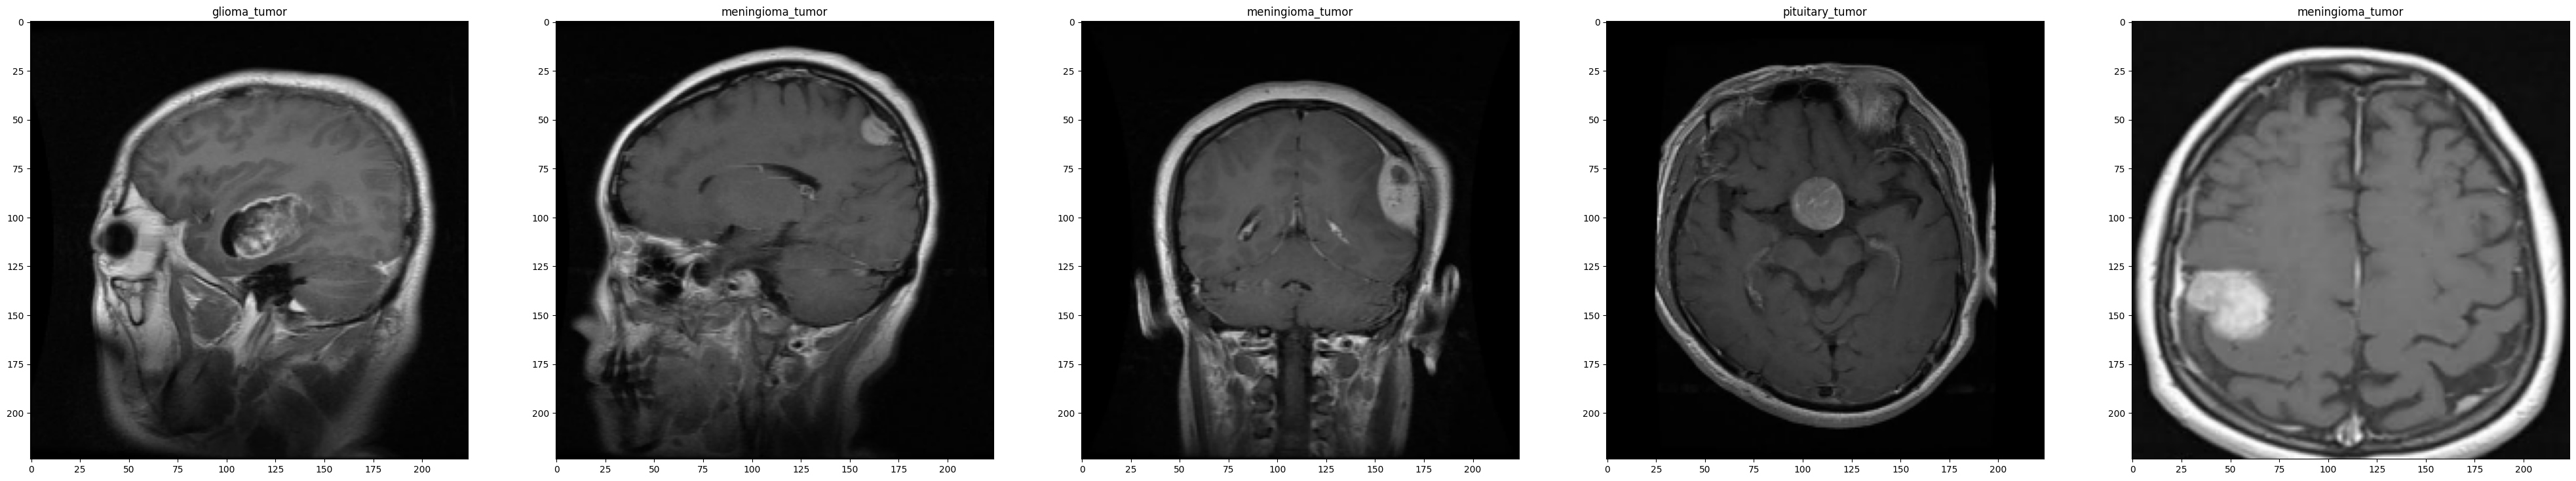

In [ ]:
"""
Plotting some of the data
"""

plt.figure(figsize=(50,25))  # specify plotting figure size
plot_range = 5  # specify number of plots

for i in range(plot_range):
    plot_idx = random.randrange(0, len(X))  # return random plots
    plt.subplot(1,plot_range,i+1)
    plt.imshow(X[plot_idx])
    plt.title(y[plot_idx])

In [ ]:
"""
Split image/label data into testing and training
"""

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=101)

In [ ]:
"""
converting labels to keras categorical object
"""

y_train_new = []
for i in y_train:
    y_train_new.append(classes.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(classes.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

  0%|          | 0/826 [00:00<?, ?it/s]


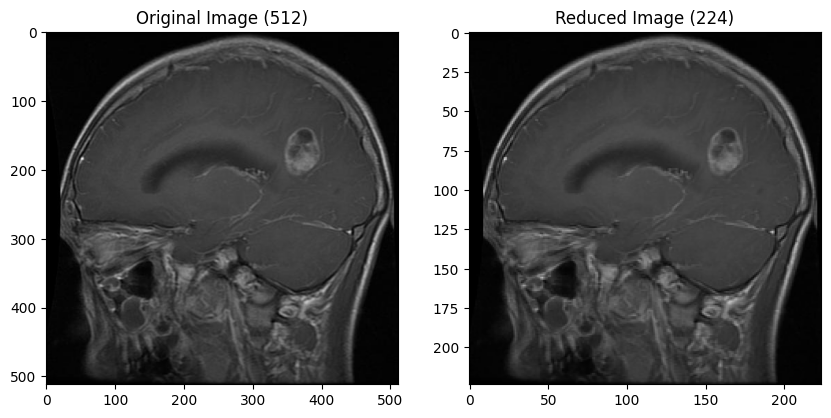

In [ ]:
"""
showing 512 vs 224 image for report
"""
classes = os.listdir("/content/drive/My Drive/data_2/Training")  # types of tumor
image_size = 224
img_512 = 0
img_224 = 0
# loop through directory
for i in classes:
    folderPath = os.path.join('/content/drive/My Drive/data_2/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(512, 512))
        img_512 = img
        img = cv2.resize(img,(image_size, image_size))
        img_224 = img
        break
fig = plt.figure(figsize = (10, 7.2))
fig.add_subplot(121)
plt.title("Original Image (512)")
plt.imshow(img_512)
fig.add_subplot(1, 2, 2)
plt.title("Reduced Image (224)")
plt.imshow(img_224)
plt.show()

# **CNN**
CNN reads raw data because part of the model is feature extraction

In [ ]:
"""
Load pre-trained CNN models
These are basically models that other people researched/built and fine tuned the convolutional layers and trained them
immense reductions in training speed with these
weights='imagenet' allows the model to be generalized to more applications
"""
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
! pip install keras tensorflow;
def extract_VGG16(tensor):
	from keras.applications.vgg16 import VGG16, preprocess_input
	return VGG16(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_VGG19(tensor):
	from keras.applications.vgg19 import VGG19, preprocess_input
	return VGG19(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_Resnet50(tensor):
	#from keras.applications.resnet50 import ResNet50, preprocess_input
	#from tensorflow.python.keras.applications import ResNet50
	return ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

# apparently there is a resnet 101 and resnet 152 as well

def extract_Xception(tensor):
	from keras.applications.xception import Xception, preprocess_input
	return Xception(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

def extract_InceptionV3(tensor):
	from keras.applications.inception_v3 import InceptionV3, preprocess_input
	return InceptionV3(weights='imagenet', include_top=False).predict(preprocess_input(tensor))

In [ ]:
# keep track of epoch accuracy
class CNN_History(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
        self.precision = []
        self.recall = []
        self.v_acc = []
        self.v_loss = []
        self.v_precision = []
        self.v_recall = []


    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs.get('Accuracy'))
        self.loss.append(logs.get('loss'))
        self.precision.append(logs.get('precision'))
        self.recall.append(logs.get('recall'))
        self.v_acc.append(logs.get('val_Accuracy'))
        self.v_loss.append(logs.get('val_loss'))
        self.v_precision.append(logs.get('val_precision'))
        self.v_recall.append(logs.get('val_recall'))

cnn_history = CNN_History()


## **CNN - VGG16**

In [ ]:
# VGG16 hitting ~83%
x_train_features = extract_VGG16(X_train)
x_test_features = extract_VGG16(X_test)

19/19 [==============================] - 4s 196ms/step


In [ ]:
"""
push the feature extracted information into CNN
"""

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=x_train_features.shape[1:]))
model.add(Dense(4, activation='softmax'))

model.summary()
print(x_train_features.shape[1:])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 2052 (8.02 KB)
Trainable params: 2052 (8.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
(7, 7, 512)


In [ ]:
"""
compile model
choose optimizer, they do different stuff but idk why
"""

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy', "Precision", "Recall"])
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [ ]:
"""
fit the model
this will print out accuracy and loss for each epoch
fine tune learning rate, epochs, batch size
"""

# store the trained model somewhere, can call this after its trained to skip train steps
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/data_2/saved_models/weights.best.VGG16.hdf5',
                               verbose=1, save_best_only=True)

# adjust learning rate
# ADAM optimizer can set learning rate on its own, comment out when using adam
K.set_value(model.optimizer.learning_rate, 0.1)
model.fit(x_train_features, y_train,
          validation_data=(x_test_features, y_test),
          epochs=50, batch_size=16, callbacks=[checkpointer, cnn_history], verbose=1)

Epoch 1/50
143/147 [============================>.] - ETA: 0s - loss: 37.3277 - accuracy: 0.6128
Epoch 1: val_loss improved from inf to 9.29957, saving model to /content/drive/My Drive/data_2/saved_models/weights.best.VGG16.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 2s 10ms/step - loss: 37.1247 - accuracy: 0.6135 - val_loss: 9.2996 - val_accuracy: 0.8146
Epoch 2/50
143/147 [============================>.] - ETA: 0s - loss: 15.0948 - accuracy: 0.7640
Epoch 2: val_loss did not improve from 9.29957
147/147 [==============================] - 1s 4ms/step - loss: 15.2945 - accuracy: 0.7619 - val_loss: 10.5151 - val_accuracy: 0.7721
Epoch 3/50
134/147 [==========================>...] - ETA: 0s - loss: 11.6948 - accuracy: 0.8046
Epoch 3: val_loss improved from 9.29957 to 5.47815, saving model to /content/drive/My Drive/data_2/saved_models/weights.best.VGG16.hdf5
147/147 [==============================] - 1s 4ms/step - loss: 11.6447 - accuracy: 0.8023 - val_loss: 5.4782 - val_accuracy: 0.8776
Epoch 4/50
147/147 [==============================] - ETA: 0s - loss: 8.9732 - accuracy: 0.8299
Epoch 4: val_loss did not improve from 5.47815
147/147 [==============================] - 1s 4ms/step - loss: 8.9732 - accuracy: 

In [ ]:
# Get index of predicted tumor for each image in the test set
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in x_test_features];

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(y_test, axis=1))/len(predictions);
print('Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
#Rocco Post Run Metric evaluations
print(predictions)
print(y_test.shape)
print(classes)
predcat = tf.keras.utils.to_categorical(predictions)
print(predcat)
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y_test, predcat)
print("\nAccuracy")
print(accuracy.result().numpy())

m = tf.keras.metrics.Precision()
m.update_state(y_test, predcat)
m.result().numpy()
print("\nPrecision")
print(m.result().numpy())

#s = tf.keras.metrics.Recall()
#s.update_state(y_test, predcat)
#s.result().numpy()
#print("\nRecall")
#print(s.result().numpy())

f1 = tf.keras.metrics.F1Score()
f1.update_state(y_test, predcat)
f1s = f1.result().numpy()
print("\nF1 Score")
f1.result().numpy()

results = model.evaluate(x_test_features, y_test)

[2, 2, 1, 1, 0, 0, 2, 3, 0, 1, 2, 0, 3, 1, 0, 1, 3, 2, 0, 1, 2, 0, 0, 0, 2, 2, 3, 1, 0, 0, 1, 0, 3, 2, 2, 1, 2, 1, 2, 0, 2, 0, 1, 0, 2, 0, 0, 1, 0, 0, 1, 1, 1, 0, 2, 0, 0, 2, 0, 2, 1, 1, 2, 3, 0, 2, 2, 2, 1, 2, 0, 2, 3, 3, 3, 2, 3, 1, 3, 2, 1, 0, 2, 2, 2, 1, 3, 0, 0, 1, 2, 2, 3, 3, 3, 2, 3, 0, 2, 0, 2, 1, 2, 2, 0, 0, 2, 0, 0, 3, 2, 1, 3, 3, 0, 2, 3, 3, 0, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 0, 0, 3, 1, 3, 3, 1, 0, 1, 2, 0, 1, 3, 1, 2, 3, 2, 1, 1, 1, 2, 0, 1, 1, 2, 2, 3, 3, 2, 2, 2, 2, 0, 1, 2, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 2, 3, 2, 0, 2, 3, 1, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 1, 0, 1, 1, 2, 1, 2, 3, 2, 0, 3, 2, 2, 1, 2, 1, 1, 0, 3, 1, 0, 0, 2, 1, 0, 2, 1, 2, 2, 2, 1, 0, 1, 3, 0, 3, 1, 1, 0, 2, 2, 1, 1, 2, 1, 0, 3, 1, 2, 1, 1, 2, 1, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 3, 3, 1, 1, 1, 1, 2, 0, 3, 2, 1, 2, 3, 0, 3, 0, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 3, 0, 2, 2, 0, 0, 0, 3, 3, 2, 2, 0, 0, 1, 2, 1, 0, 2, 3, 3, 0, 2, 2, 0, 2, 3, 0, 2, 2, 0, 0, 0, 0, 0, 3, 0, 2, 2, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 

### **Visualization (VGG16)**
Displaying Convergence and Useful Metrics

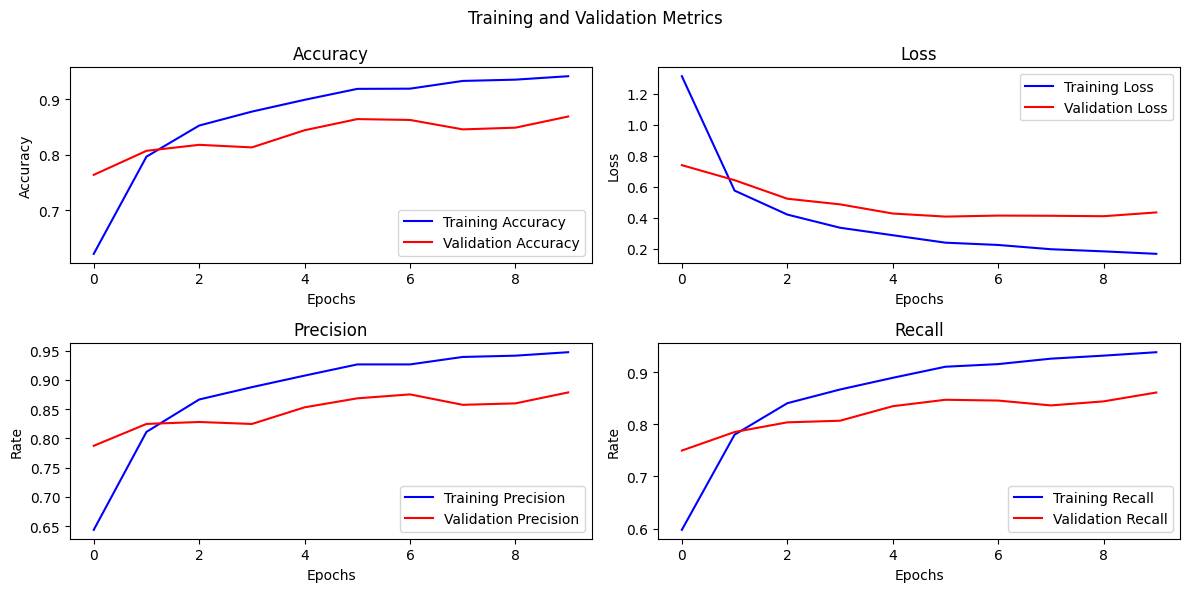

In [ ]:
epochs = range(len(cnn_history.acc))

plt.figure(figsize=(12, 6))
plt.suptitle("Training and Validation Metrics")

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, cnn_history.acc, 'b', label='Training Accuracy')
plt.plot(epochs, cnn_history.v_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, cnn_history.loss, 'b', label='Training Loss')
plt.plot(epochs, cnn_history.v_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, cnn_history.precision, 'b', label='Training Precision')
plt.plot(epochs, cnn_history.v_precision, 'r', label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, cnn_history.recall, 'b', label='Training Recall')
plt.plot(epochs, cnn_history.v_recall, 'r', label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
"""
First, hot-coded y_test into 1d list
Then create confusion matrix.
"""

y_test_indices = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_indices, predictions)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix with VGG16")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

NameError: ignored

<Figure size 800x600 with 0 Axes>

In [ ]:
# Confusion Matrices for Each Class
cat_pred = tf.keras.utils.to_categorical(predictions)
confusion_matrices = []
confusion_matrices.append(confusion_matrix(y_test[:,0], cat_pred[:,0]))
confusion_matrices.append(confusion_matrix(y_test[:,1], cat_pred[:,1]))
confusion_matrices.append(confusion_matrix(y_test[:,2], cat_pred[:,2]))
confusion_matrices.append(confusion_matrix(y_test[:,3], cat_pred[:,3]))
print(confusion_matrices)
accuracies = []
class_labels = ["glioma", "pituitary", "meningioma", "no_tumor"]
for i in range(len(confusion_matrices)):
  print("\n" + classes[i])
  cm = confusion_matrices[i]
  acc_preds = cm[0,0] + cm[1,1]
  inacc_preds = cm[0,1] + cm[1,0]
  acc = acc_preds / (acc_preds + inacc_preds)
  print("Accuracy: " + str(acc))
  print(cm)
  accuracies.append(acc)

accuracies = [round(i, 3) for i in accuracies]
fig, ax = plt.subplots()
bar_container = ax.bar(class_labels, accuracies)
ax.bar_label(bar_container, label_type='center')

# Adding labels and a title
plt.xlabel('Tumor Types')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy By Class')

# Display the graph
plt.show()
print(np.sum(predictions[predictions==1]))

In [ ]:
f1s = [round(i, 3) for i in f1s]
class_labels = ["glioma", "pituitary", "meningioma", "no_tumor"]
fig, ax = plt.subplots()
bar_container = ax.bar(class_labels, f1s)
ax.bar_label(bar_container, label_type='center')
plt.xlabel('Tumor Types')
plt.ylabel('F1 Score')
plt.title('F1 Score By Class')
plt.show()

## **CNN - ResNet50**

In [ ]:
# Resnet 50 hitting ~ 91% for adam, 15 epoch, 10 batch size
x_train_features = extract_Resnet50(X_train)
x_test_features = extract_Resnet50(X_test)

21/21 [==============================] - 4s 112ms/step


In [ ]:
"""
push the feature extracted information into CNN
"""

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=x_train_features.shape[1:]))
model.add(Dense(4, activation='softmax'))

model.summary()
print(x_train_features.shape[1:])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 8196 (32.02 KB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
(7, 7, 2048)


In [ ]:
"""
compile model
choose optimizer, they do different stuff but idk why
"""

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['Accuracy', "Precision", "Recall"])
#model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [ ]:
"""
fit the model
this will print out accuracy and loss for each epoch
fine tune learning rate, epochs, batch size
"""

# store the trained model somewhere, can call this after its trained to skip train steps
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/data_2/saved_models/weights.best.ResNet50.hdf5',
                               verbose=1, save_best_only=True)

# adjust learning rate
# ADAM optimizer can set learning rate on its own, comment out when using adam
#K.set_value(model.optimizer.learning_rate, 0.0003)
model.fit(x_train_features, y_train,
          validation_data=(x_test_features, y_test),
          epochs=15, batch_size=10, callbacks=[checkpointer, cnn_history], verbose=1)

Epoch 1/50
253/259 [============================>.] - ETA: 0s - loss: 0.6637 - Accuracy: 0.7328 - precision: 0.7892 - recall: 0.6644
Epoch 1: val_loss improved from inf to 0.44757, saving model to /content/drive/My Drive/data_2/saved_models/weights.best.ResNet50.hdf5
259/259 [==============================] - 4s 12ms/step - loss: 0.6568 - Accuracy: 0.7360 - precision: 0.7918 - recall: 0.6676 - val_loss: 0.4476 - val_Accuracy: 0.8223 - val_precision: 0.8550 - val_recall: 0.7929
Epoch 2/50
251/259 [============================>.] - ETA: 0s - loss: 0.3853 - Accuracy: 0.8550 - precision: 0.8792 - recall: 0.8351
Epoch 2: val_loss improved from 0.44757 to 0.34706, saving model to /content/drive/My Drive/data_2/saved_models/weights.best.ResNet50.hdf5
259/259 [==============================] - 2s 9ms/step - loss: 0.3847 - Accuracy: 0.8547 - precision: 0.8787 - recall: 0.8342 - val_loss: 0.3471 - val_Accuracy: 0.8671 - val_precision: 0.8943 - val_recall: 0.8501
Epoch 3/50
254/259 [=============

In [ ]:
#Load the best weights to skip training
model.load_weights('/content/drive/My Drive/data_2/saved_models/weights.best.ResNet50.hdf5')

In [ ]:
# Get index of predicted tumor for each image in the test set
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in x_test_features];

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(y_test, axis=1))/len(predictions);
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 18ms/step
Test accuracy: 91.0355%


### **Visualization (ResNet50)**


In [ ]:
#Rocco Post Run Metric evaluations
print(predictions)
print(y_test.shape)
print(classes)
predcat = tf.keras.utils.to_categorical(predictions)

accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(y_test, predcat)
print("\nAccuracy")
print(accuracy.result().numpy())

m = tf.keras.metrics.Precision()
m.update_state(y_test, predcat)
m.result().numpy()
print("\nPrecision")
print(m.result().numpy())

#s = tf.keras.metrics.Recall()
#s.update_state(y_test, predcat)
#s.result().numpy()
#print("\nRecall")
#print(s.result().numpy())

f1 = tf.keras.metrics.F1Score()
f1.update_state(y_test, predcat)
f1s = f1.result().numpy()
print("\nF1 Score")
f1.result().numpy()

results = model.evaluate(x_test_features, y_test)

[2, 2, 1, 1, 0, 0, 2, 3, 0, 1, 2, 0, 3, 1, 0, 1, 3, 0, 0, 1, 1, 0, 0, 0, 2, 2, 3, 1, 0, 0, 1, 0, 3, 2, 2, 1, 0, 1, 2, 0, 0, 0, 1, 0, 2, 2, 0, 1, 0, 0, 2, 1, 1, 0, 2, 0, 0, 0, 0, 2, 1, 1, 2, 3, 0, 2, 2, 0, 1, 2, 2, 2, 3, 3, 3, 2, 3, 1, 3, 2, 1, 0, 2, 2, 1, 1, 2, 0, 0, 1, 2, 2, 2, 3, 3, 2, 3, 0, 2, 0, 0, 1, 2, 1, 0, 0, 2, 0, 0, 3, 2, 1, 3, 3, 2, 2, 3, 3, 0, 2, 2, 3, 2, 2, 3, 2, 3, 0, 3, 2, 0, 3, 0, 0, 0, 3, 1, 3, 3, 1, 0, 1, 2, 0, 1, 3, 1, 2, 3, 2, 1, 2, 1, 2, 0, 1, 1, 3, 2, 1, 3, 2, 2, 2, 0, 0, 1, 2, 0, 1, 0, 0, 2, 2, 2, 1, 0, 1, 2, 3, 2, 0, 2, 3, 1, 2, 2, 2, 0, 2, 2, 1, 0, 1, 2, 1, 0, 1, 1, 2, 1, 2, 3, 0, 0, 3, 2, 1, 1, 1, 1, 1, 3, 3, 1, 0, 0, 2, 1, 0, 2, 2, 1, 3, 3, 1, 0, 1, 2, 0, 2, 1, 1, 0, 2, 0, 1, 1, 2, 1, 0, 3, 1, 0, 1, 1, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2, 1, 3, 3, 1, 1, 1, 1, 2, 0, 3, 2, 1, 2, 3, 0, 3, 0, 2, 3, 1, 0, 1, 1, 2, 2, 2, 0, 3, 2, 2, 2, 0, 0, 0, 3, 3, 2, 2, 0, 0, 1, 2, 1, 0, 0, 3, 3, 0, 2, 2, 0, 2, 3, 0, 2, 1, 0, 0, 0, 0, 0, 3, 2, 0, 2, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 

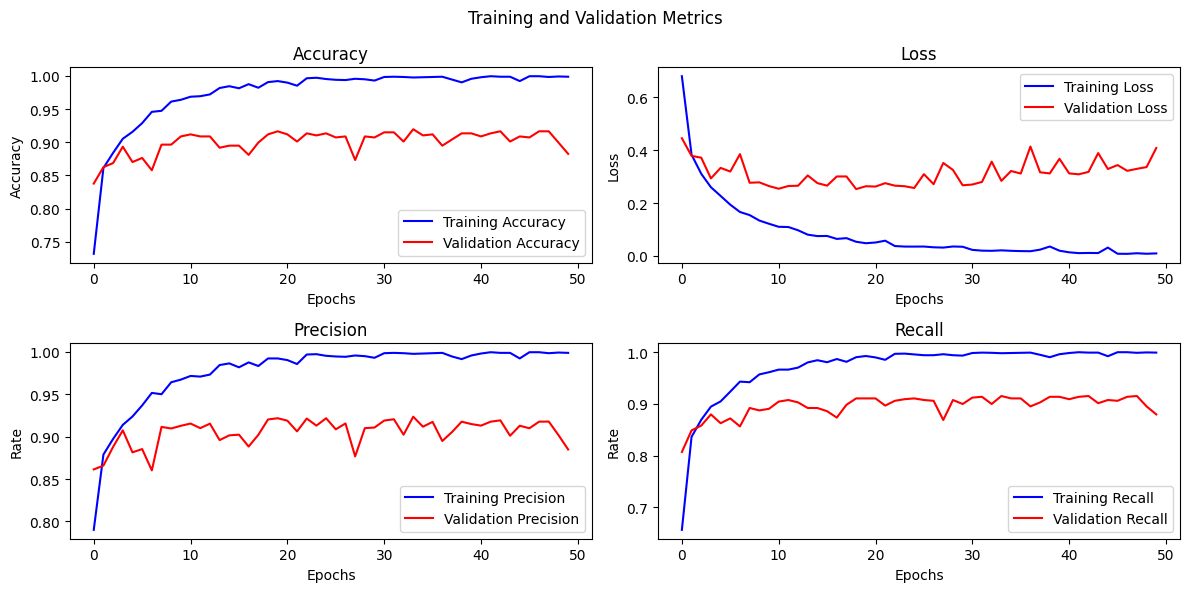

In [ ]:
epochs = range(len(cnn_history.acc))

plt.figure(figsize=(12, 6))
plt.suptitle("Training and Validation Metrics")

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, cnn_history.acc, 'b', label='Training Accuracy')
plt.plot(epochs, cnn_history.v_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, cnn_history.loss, 'b', label='Training Loss')
plt.plot(epochs, cnn_history.v_loss, 'r', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, cnn_history.precision, 'b', label='Training Precision')
plt.plot(epochs, cnn_history.v_precision, 'r', label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.legend()

# Recall
plt.subplot(2, 2, 4)
plt.plot(epochs, cnn_history.recall, 'b', label='Training Recall')
plt.plot(epochs, cnn_history.v_recall, 'r', label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Rate')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
"""
First, hot-coded y_test into 1d list
Then create confusion matrix.
"""

y_test_indices = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_indices, predictions)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix with ResNet50")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
cat_pred = tf.keras.utils.to_categorical(predictions)
# Confusion Matrices for Each Class
confusion_matrices = []
confusion_matrices.append(confusion_matrix(y_test[:,0], cat_pred[:,0]))
confusion_matrices.append(confusion_matrix(y_test[:,1], cat_pred[:,1]))
confusion_matrices.append(confusion_matrix(y_test[:,2], cat_pred[:,2]))
confusion_matrices.append(confusion_matrix(y_test[:,3], cat_pred[:,3]))

accuracies = []
class_labels = ["glioma", "pituitary", "meningioma", "no_tumor"]
for i in range(len(confusion_matrices)):
  print("\n" + classes[i])
  cm = confusion_matrices[i]
  acc_preds = cm[0,0] + cm[1,1]
  inacc_preds = cm[0,1] + cm[1,0]
  acc = acc_preds / (acc_preds + inacc_preds)
  print("Accuracy: " + str(acc))
  print(cm)
  accuracies.append(acc)

accuracies = [round(i, 3) for i in accuracies]
fig, ax = plt.subplots()
bar_container = ax.bar(class_labels, accuracies)
ax.bar_label(bar_container, label_type='center')

# Adding labels and a title
plt.xlabel('Tumor Types')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy By Class')

# Display the graph
plt.show()
print(np.sum(predictions[predictions==1]))

In [ ]:
f1s = [round(i, 3) for i in f1s]
class_labels = ["glioma", "pituitary", "meningioma", "no_tumor"]
fig, ax = plt.subplots()
bar_container = ax.bar(class_labels, f1s)
ax.bar_label(bar_container, label_type='center')
plt.xlabel('Tumor Types')
plt.ylabel('F1 Score')
plt.title('F1 Score By Class')
plt.show()

# **SVM Data Processing**
PCA & grayscale conversion

## PCA Implementation

reduced to 50 principal components with 99% retained variance

In [ ]:
"""
function to calculate PCA for each image in a set
pass in a set of images, get the images back reduced information
specify number of components to keep
"""

def color_pca(color_image_set, n_components):
    pca_set = []
    print_size = 1
    plot_out = 1
    i = 0
    for img in color_image_set:
        blue,green,red = cv2.split(img)
        # pca = PCA(n_components=0.99, svd_solver='full')
        pca = PCA(n_components=n_components)
        red_transformed = pca.fit_transform(red)
        red_inverted = pca.inverse_transform(red_transformed)
        green_transformed = pca.fit_transform(green)
        green_inverted = pca.inverse_transform(green_transformed)
        blue_transformed = pca.fit_transform(blue)
        blue_inverted = pca.inverse_transform(blue_transformed)
        img_compressed = (np.dstack((red_inverted, red_inverted, red_inverted))).astype(np.uint8)
        pca_set.append(img_compressed)

        if print_size:
            print(f"Explained Variance : {sum(pca.explained_variance_ratio_)}")
            print_size = 0

        if plot_out:
            fig = plt.figure(figsize = (10, 7.2))
            fig.add_subplot(121)
            plt.title("Original Image")
            plt.imshow(img)
            fig.add_subplot(122)
            plt.title("Reduced Image")
            plt.imshow(img_compressed)
            plt.show()
            plot_out = 0
        i += 1
    return np.array(pca_set)


Explained Variance : 0.991557831264042


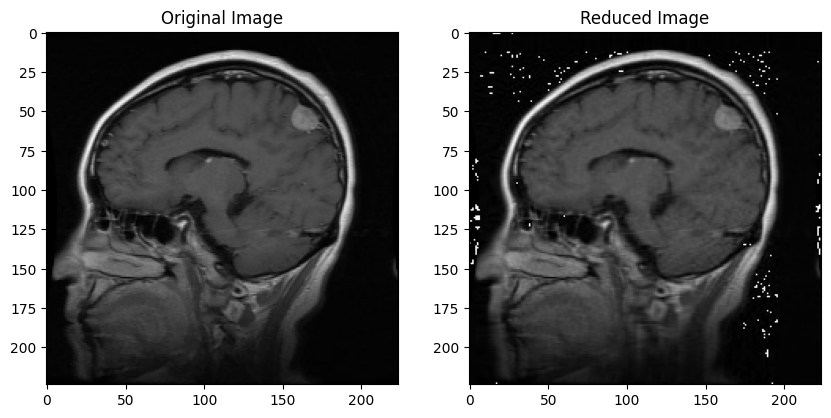

Explained Variance : 0.9829440713389522


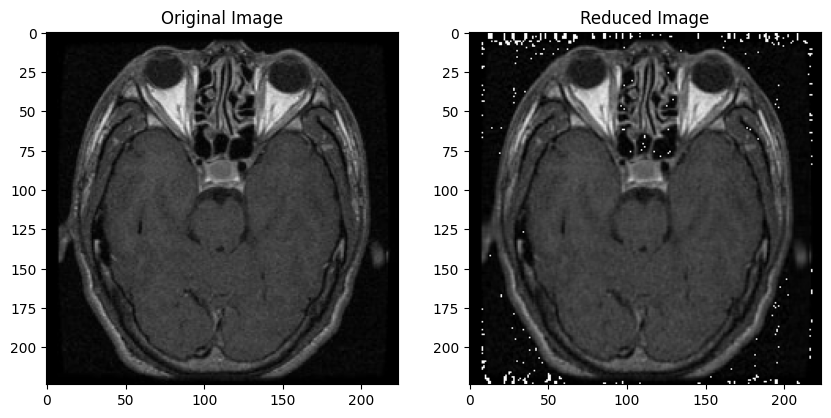

KeyboardInterrupt: ignored

In [ ]:

"""
run conversion function to apply to new data sets
n_components >= ? pushed explained variance retention over 0.99
"""
X_train_pca = color_pca(X_train, 50)
X_test_pca = color_pca(X_test, 55)

## Convert to grayscale

**NOT USED**

In [ ]:
"""
function to convert an image to gray scale - removes color dimension of image
pass in set of color images, it will return a set of grayscale images
"""

def convert_to_grayscale(color_image_set):
  grayscale_set = []
  print_size = 1
  plot_out = 1
  i = 0
  for img in color_image_set:
    orig_size = img.shape
    grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    new_size = grayscale_image.shape
    grayscale_set.append(grayscale_image)
    i += 1
    if print_size:
      print(f"original shape: {orig_size}\n")
      print(f"new shape: {new_size}")
      print_size = 0
    if plot_out:
      plt.imshow(grayscale_image, cmap='gray')
      plt.show()
      grayscale_image.shape
      plot_out = 0
  return np.array(grayscale_set)

original shape: (224, 224, 3)

new shape: (224, 224)


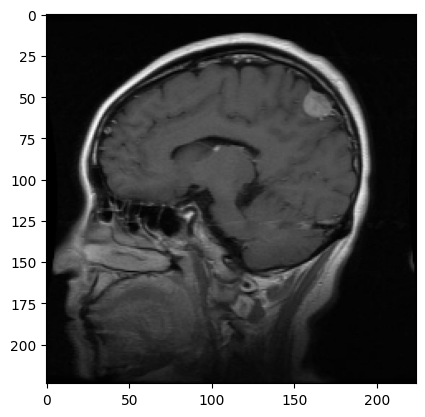

original shape: (224, 224, 3)

new shape: (224, 224)


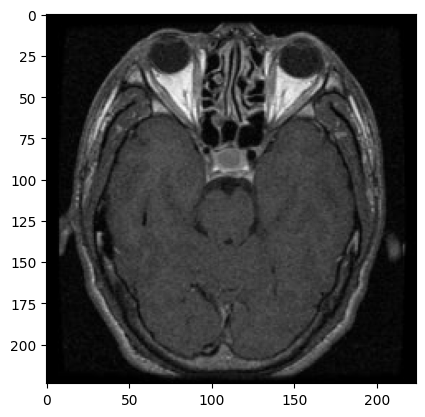

In [ ]:
"""
run conversion function to apply to new data sets
"""
X_train_2d = convert_to_grayscale(X_train)
X_test_2d = convert_to_grayscale(X_test)

# SVM

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
"""
reading in the data again so can make the necesary transformations to push into a SVM
Note: NO conversion to keras categorical objects here
"""
X = []
y = []
image_size = 224  # actual image size is 512, VGG model wants 224 images

classes = os.listdir("/content/drive/My Drive/data_2/Training")  # types of tumor

# loop through directory
for i in classes:
    folderPath = os.path.join('/content/drive/My Drive/data_2/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

X = np.array(X)  # Access image
y = np.array(y)  # labels

100%|██████████| 826/826 [00:04<00:00, 194.52it/s]


In [ ]:
"""
SVM requires a 1 dimensional X input
This function will read in the list of images and flatten to 1D
It will also normalize the input to 0, 1 range
returns a list of the altered images
"""
def flattener(images):
    flattened_set = []
    scaler = MinMaxScaler()

    for img in images:
        flattened_img = img.reshape(-1)
        flattened_set.append(flattened_img)

    flattened_set = np.array(flattened_set)
    scaled_set = scaler.fit_transform(flattened_set)

    return scaled_set

In [ ]:
"""
Converting the array of tumor name to a number encoded equivalence
for example:
[glioma, glioma, no tumor, pituitary, no tumor] -> [0, 0, 1, 2, 1]
Access the original labels with: .inverse_transform
"""

label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(y)

Explained Variance : 0.9901239960758466


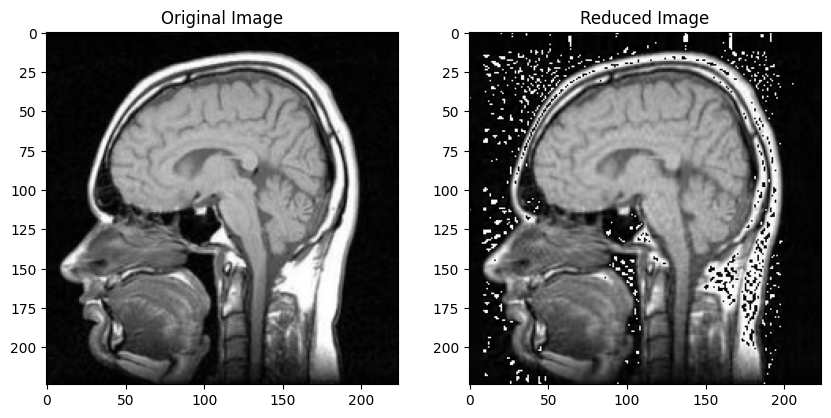

In [ ]:
"""
Apply PCA and flattening to the images
will take a few minutes to run
"""

X_pca = color_pca(X, 0.99)
X_svm = flattener(X_pca)
# X_svm = flattener(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_svm, numeric_labels, test_size=0.2, random_state=42)

In [ ]:
"""
Construct the model
will take a few minutes to run
can fine tune C and gamma
"""
#model = SVC(kernel='linear', C=1, gamma='auto')
model.fit(X_train, y_train)

SVC(C=0.1, gamma=0.1, kernel='linear')

In [ ]:
"""
generate  predictions for model
"""

predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

# 85 % accuracy with PCA data
# 81 % accuracy without PCA

Accuracy: 0.8516228748068007


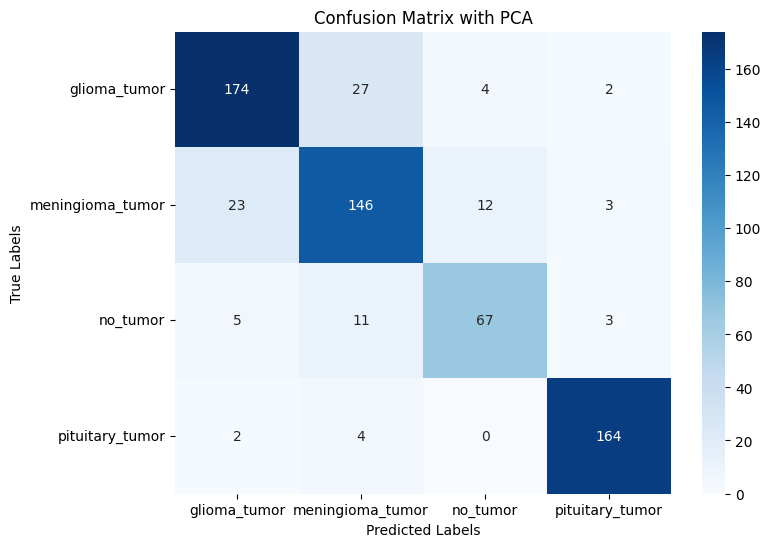

In [ ]:
"""
First, convert the transformed y set back to string labels
Then create confusion matrix
"""
pred_labeled = label_encoder.inverse_transform(predictions)
test_labeled = label_encoder.inverse_transform(y_test)

conf_matrix = confusion_matrix(test_labeled, pred_labeled)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.title("Confusion Matrix without PCA")
plt.title("Confusion Matrix with PCA")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
"""
Calculating precision for each class
"""

tumor_truth = 0
tumor_pred = 0
for i in range(len(test_labeled)):
    if test_labeled[i] != 'no_tumor':
        tumor_truth += 1
        if pred_labeled[i] != 'no_tumor':
            tumor_pred += 1
print(f"Correctly identifying tumor presence: {tumor_pred / tumor_truth}")
glioma_truth = 0
glioma_pred = 0
for i in range(len(test_labeled)):
    if test_labeled[i] == 'glioma_tumor':
        glioma_truth += 1
        if pred_labeled[i] == 'glioma_tumor':
            glioma_pred += 1
print(f"Correctly identifying glioma: {glioma_pred / glioma_truth}")
meningioma_truth = 0
meningioma_pred = 0
for i in range(len(test_labeled)):
    if test_labeled[i] == 'meningioma_tumor':
        meningioma_truth += 1
        if pred_labeled[i] == 'meningioma_tumor':
            meningioma_pred += 1
print(f"Correctly identifying meningioma: {meningioma_pred / meningioma_truth}")
pituitary_truth = 0
pituitary_pred = 0
for i in range(len(test_labeled)):
    if test_labeled[i] == 'pituitary_tumor':
        pituitary_truth += 1
        if pred_labeled[i] == 'pituitary_tumor':
            pituitary_pred += 1
print(f"Correctly identifying pituitary: {pituitary_pred / pituitary_truth}")

Correctly identifying tumor presence: 0.9714795008912656
Correctly identifying glioma: 0.8405797101449275
Correctly identifying meningioma: 0.7934782608695652
Correctly identifying pituitary: 0.9647058823529412


In [ ]:
"""
grid search for best params
Don't run this, takes a very long time
"""

# # Create an SVM model
# svm_model = SVC(kernel='linear')

# # Define the parameter grid
# param_grid = {'C': [0.1, 1, 10, 100], 'gamma': ['auto', 0.1, 0.01, 0.001]}

# # Create the GridSearchCV object
# grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')

# # Fit the GridSearchCV object to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")

# # Get the best model
# best_model = grid_search.best_estimator_